## Data import and libraries
Import the necessary modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import re
from scipy import stats
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
data = pd.read_csv('data.csv')

data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget


## Data Analysis

Who spends the most on chips (total sales)? Let's start with describing customers by lifestage and how premium their general purchasing behaviour is
 

/root/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/root/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/root/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


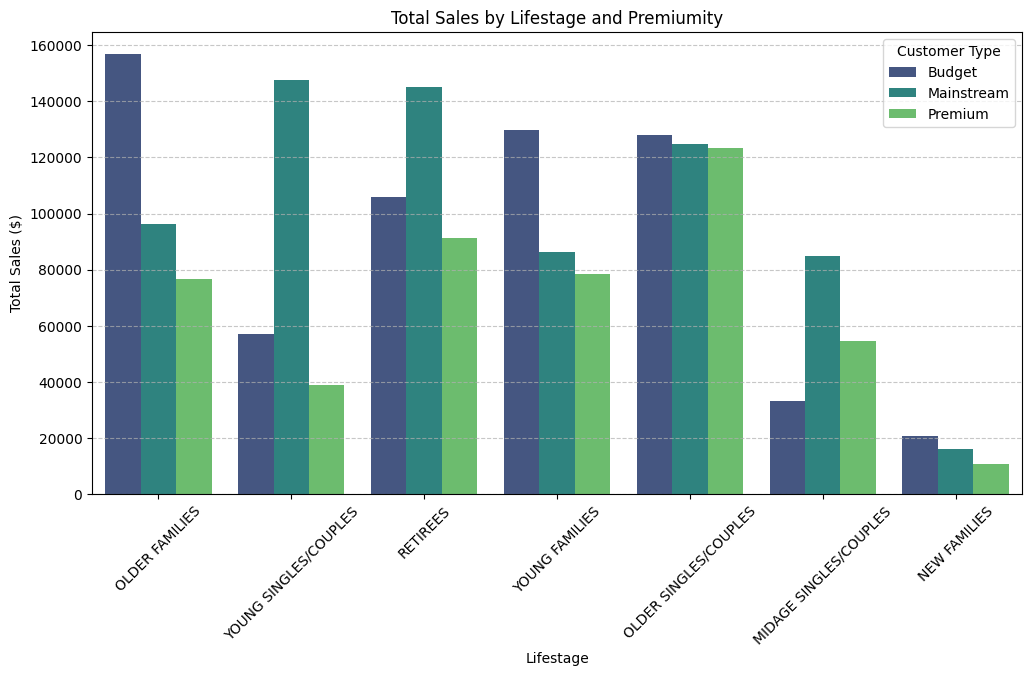

In [3]:
sales_by_segment = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
sales_by_segment.sort_values(by='TOT_SALES', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=sales_by_segment, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', palette='viridis')
plt.title('Total Sales by Lifestage and Premiumity')
plt.xlabel('Lifestage')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.legend(title='Customer Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees. Let's see if the higher sales are due to there being more customers who buy chips.

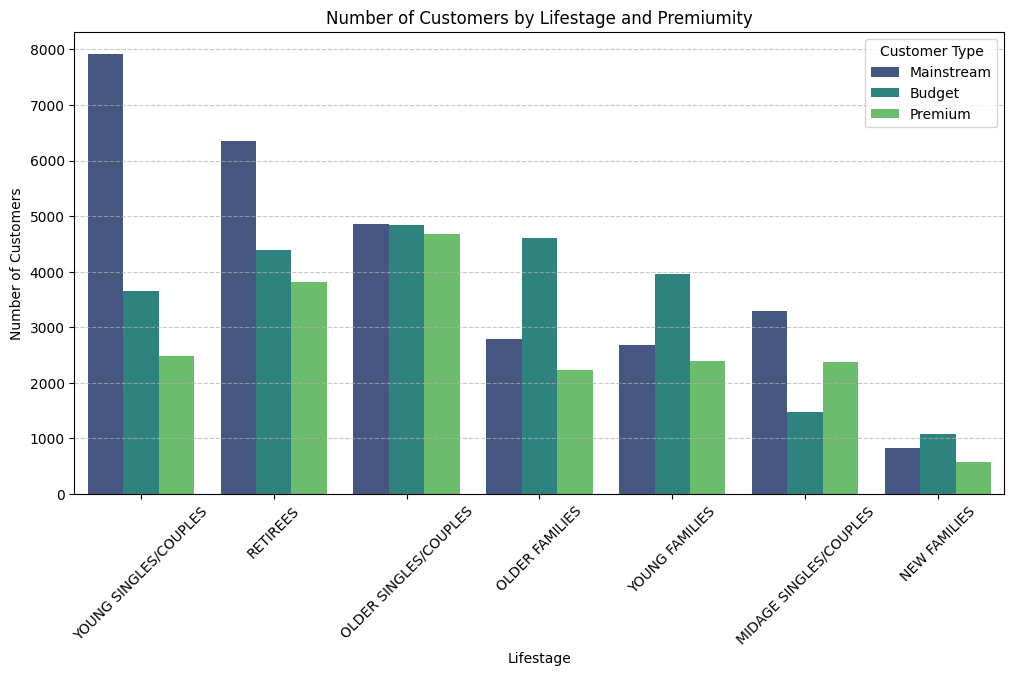

In [4]:
customer_counts = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
customer_counts.rename(columns={'LYLTY_CARD_NBR': 'CUSTOMER_COUNT'}, inplace=True)
customer_counts.sort_values(by='CUSTOMER_COUNT', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=customer_counts, x='LIFESTAGE', y='CUSTOMER_COUNT', hue='PREMIUM_CUSTOMER', palette='viridis')
plt.title('Number of Customers by Lifestage and Premiumity')
plt.xlabel('Lifestage')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Customer Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment. Higher sales may also be driven by more units of chips being bought per customer.  Let's have a look at this next.

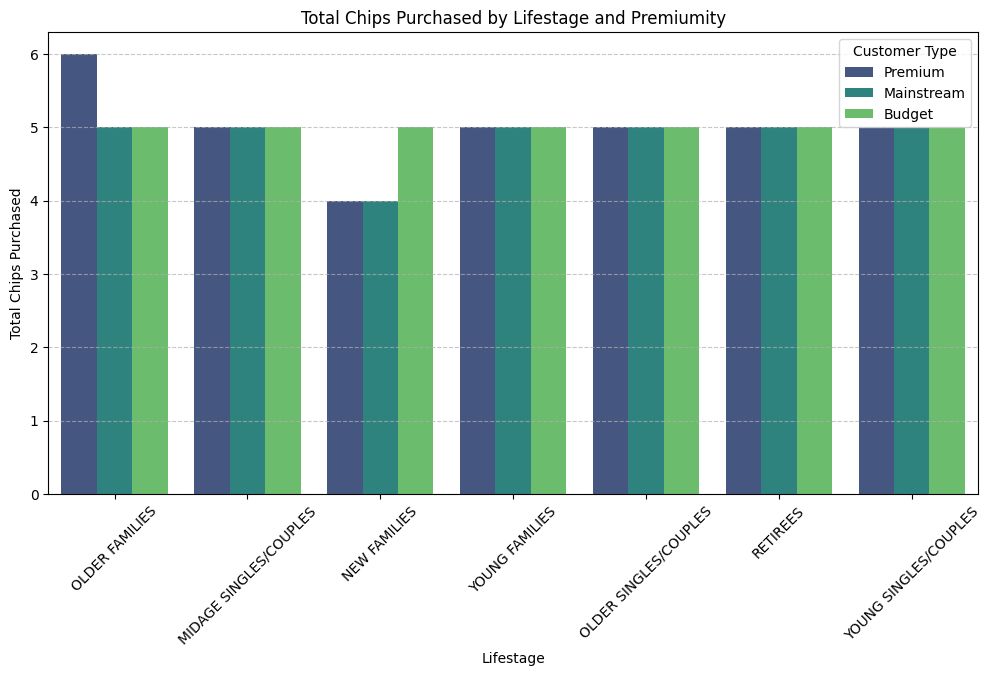

In [31]:
chips_purchased = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].nunique().reset_index()
chips_purchased.rename(columns={'PROD_QTY': 'PURCHASED_CHIPS'}, inplace=True)
chips_purchased.sort_values(by='PURCHASED_CHIPS', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=chips_purchased, x='LIFESTAGE', y='PURCHASED_CHIPS', hue='PREMIUM_CUSTOMER', palette='viridis')
plt.title('Total Chips Purchased by Lifestage and Premiumity')
plt.xlabel('Lifestage')
plt.ylabel('Total Chips Purchased')
plt.xticks(rotation=45)
plt.legend(title='Customer Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Older families and young families in general buy more chips per customer Let's also investigate the average price per unit chips bought for each customer segment as this is also a driver of total sales.

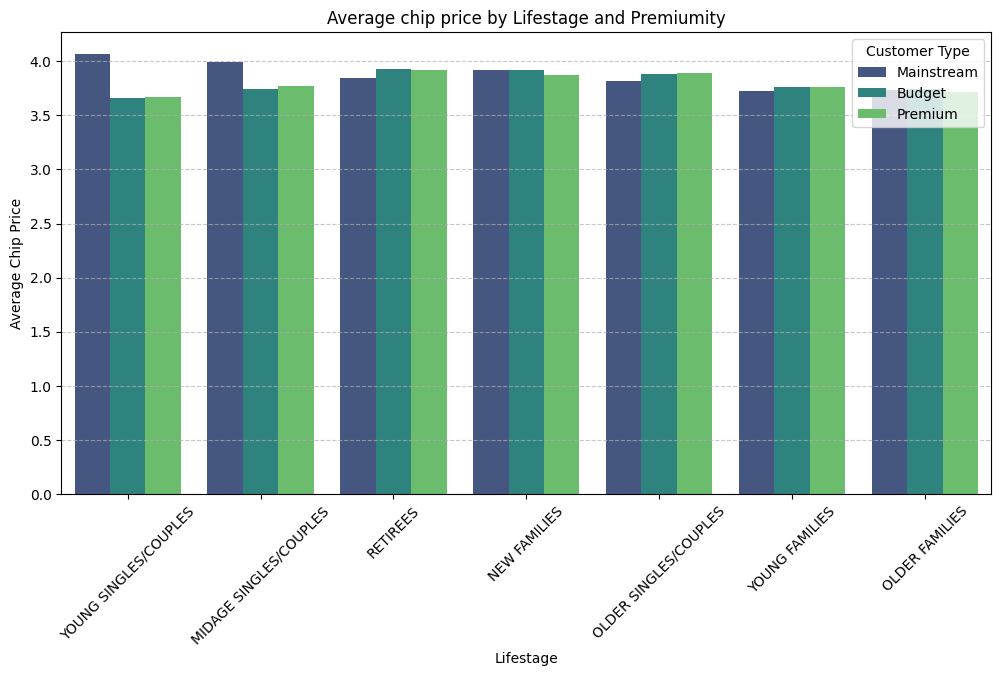

In [6]:
data['PRICE_PER_PACK'] = data['TOT_SALES'] / data['PROD_QTY']
avg_price_per_segment = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_PACK'].mean().reset_index()
avg_price_per_segment.rename(columns={'PRICE_PER_PACK': 'AVG_PRICE'}, inplace=True)
avg_price_per_segment.sort_values(by='AVG_PRICE', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_price_per_segment, x='LIFESTAGE', y='AVG_PRICE', hue='PREMIUM_CUSTOMER', palette='viridis')
plt.title('Average chip price by Lifestage and Premiumity')
plt.xlabel('Lifestage')
plt.ylabel('Average Chip Price')
plt.xticks(rotation=45)
plt.legend(title='Customer Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

As the difference in average price per unit isn't large, we can check if this difference is statistically different.

In [35]:
midage_mainstream_prices = data[(data['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]['PRICE_PER_PACK']
midage_premium_prices = data[(data['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Premium')]['PRICE_PER_PACK']
midage_budget_prices = data[(data['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Budget')]['PRICE_PER_PACK']

midage_mainstream_vs_premium = stats.ttest_ind(midage_mainstream_prices, midage_premium_prices, equal_var=False)
midage_mainstream_vs_budget = stats.ttest_ind(midage_mainstream_prices, midage_budget_prices, equal_var=False)

midage_mainstream_vs_premium, midage_mainstream_vs_budget

(Ttest_indResult(statistic=14.058650719224447, pvalue=1.2705045169661103e-44),
 Ttest_indResult(statistic=13.460396219135632, pvalue=7.064596224398621e-41))

In [33]:
young_mainstream_prices = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]['PRICE_PER_PACK']
young_premium_prices = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Premium')]['PRICE_PER_PACK']
young_budget_prices = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Budget')]['PRICE_PER_PACK']

young_mainstream_vs_premium = stats.ttest_ind(young_mainstream_prices, young_premium_prices, equal_var=False)
young_mainstream_vs_budget = stats.ttest_ind(young_mainstream_prices, young_budget_prices, equal_var=False)

young_mainstream_vs_premium, young_mainstream_vs_budget

(Ttest_indResult(statistic=24.777379661429638, pvalue=4.0639607781958196e-131),
 Ttest_indResult(statistic=29.522268430576997, pvalue=2.795698078070072e-186))

Such high t-values indicate a substantial difference between the groups, and the extremely small p-values suggest that this difference is highly statistically significant. Since both p-values are far below common significance thresholds (e.g., 0.05 or 0.01), we can reject the null hypothesis, meaning the two groups' means are significantly different. The large magnitude of the t-statistics also suggests that this difference is not just statistically significant but potentially meaningful in practical terms.

We have found quite a few interesting insights that we can dive deeper into. We might want to target customer segments that contribute the most to sales to retain them or further increase sales. Let's look at Mainstream - young singles/couples. For instance, let's find out if they tend to buy a particular brand of chips.




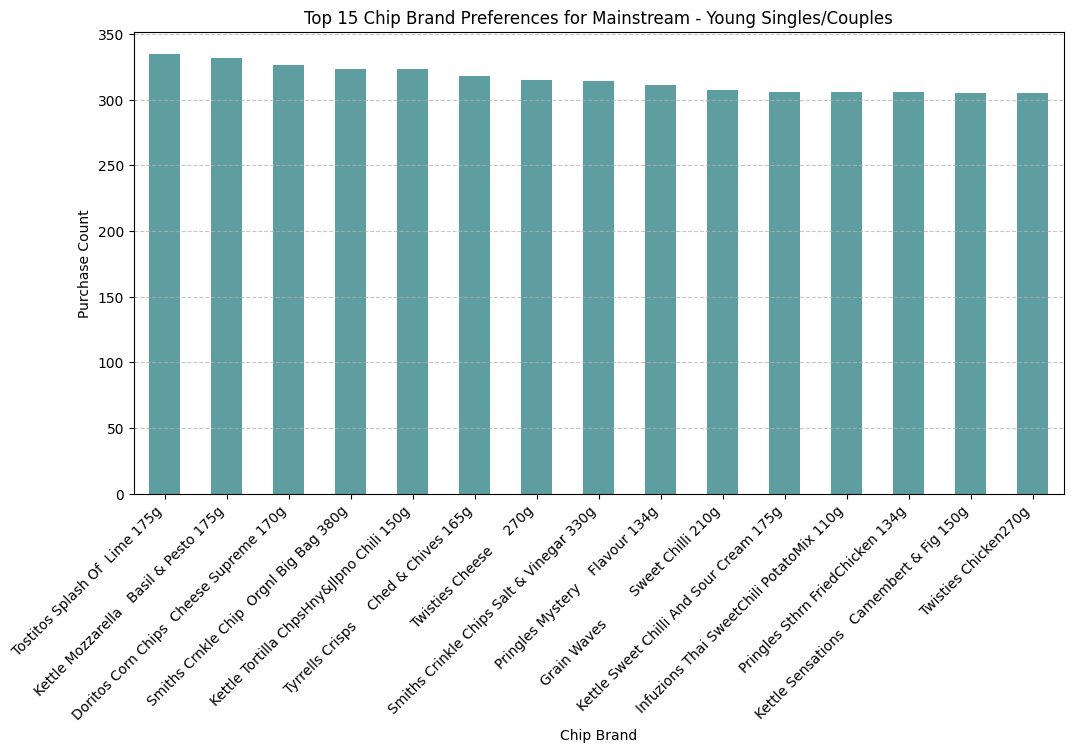

In [11]:
data_mainstream_young = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]

brand_preferences = data_mainstream_young['PROD_NAME'].value_counts().head(15)

plt.figure(figsize=(12, 6))
brand_preferences.plot(kind='bar', color='cadetblue')
plt.title('Top 15 Chip Brand Preferences for Mainstream - Young Singles/Couples')
plt.xlabel('Chip Brand')
plt.ylabel('Purchase Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Let's do a affinity analysis to see what brands the Mainstream and Young Singles/Couples prefer more than others.


In [37]:
from mlxtend.preprocessing import TransactionEncoder

data_grouped = data_mainstream_young.groupby('TXN_ID')['PROD_NAME'].apply(list)

te = TransactionEncoder()
te_ary = te.fit(data_grouped).transform(data_grouped)
encoded_data = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(encoded_data, min_support=0.005, use_colnames=True)
association_rules_result = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

association_rules_result.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


No significant association rules were identified from the dataset for Mainstream - Young Singles/Couples that meet the default lift and support criteria. Adjusting the parameters (like the minimum support or lift threshold) or refining the dataset might yield better results. Let's adjust the parameters for the analysis.

In [39]:
frequent_itemsets = apriori(encoded_data, min_support=0.001, use_colnames=True)
association_rules_result = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

association_rules_result.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


Even with adjusted parameters, no significant association rules emerged for Mainstream - Young Singles/Couples. This could mean there isn't a distinct pattern of brand preferences that satisfies the criteria. So let's inspect the individual brands statistics.

In [25]:
chip_brand_details = data_mainstream_young.groupby(['PROD_NAME']).size().reset_index(name='Purchase_Count')
chip_brand_details.sort_values(by='Purchase_Count', ascending=False, inplace=True)
chip_brand_details.head(10)

,PROD_NAME,Purchase_Count
91,Tostitos Splash Of Lime 175g,335
31,Kettle Mozzarella Basil & Pesto 175g,332
15,Doritos Corn Chips Cheese Supreme 170g,326
79,Smiths Crnkle Chip Orgnl Big Bag 380g,323
40,Kettle Tortilla ChpsHny&Jlpno Chili 150g,323
95,Tyrrells Crisps Ched & Chives 165g,318
92,Twisties Cheese 270g,315
71,Smiths Crinkle Chips Salt & Vinegar 330g,314
48,Pringles Mystery Flavour 134g,311
20,Grain Waves Sweet Chilli 210g,307



Let's do a affinity analysis to see what pack sizes the Mainstream and Young Singles/Couples prefer more than others.

In [17]:
def extract_pack_size(product_name):
    match = re.search(r'(\d+(?:g|G|ml|ML|kg|KG))', product_name)
    return match.group(0) if match else 'Unknown'

data_mainstream_young['PACK_SIZE'] = data_mainstream_young['PROD_NAME'].apply(extract_pack_size)

data_grouped_pack_size = data_mainstream_young.groupby('TXN_ID')['PACK_SIZE'].apply(list)

tp = TransactionEncoder()
te_pack_size_ary = tp.fit(data_grouped_pack_size).transform(data_grouped_pack_size)
encoded_data_pack_size = pd.DataFrame(te_pack_size_ary, columns=tp.columns_)

frequent_itemsets_pack_size = apriori(encoded_data_pack_size, min_support=0.005, use_colnames=True)
association_rules_pack_size = association_rules(frequent_itemsets_pack_size, metric="lift", min_threshold=1.0)

association_rules_pack_size.sort_values(by='lift', ascending=False).head()

/tmp/ipykernel_86/1588618174.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mainstream_young['PACK_SIZE'] = data_mainstream_young['PROD_NAME'].apply(extract_pack_size)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


No significant association rules were identified for pack size preferences among Mainstream - Young Singles/Couples using the default parameters. Further parameter adjustments or analyzing individual pack size statistics might help uncover insights.

In [19]:
# Adjusting parameters further for pack size affinity analysis
frequent_itemsets_pack_size = apriori(encoded_data_pack_size, min_support=0.0005, use_colnames=True)
association_rules_pack_size = association_rules(frequent_itemsets_pack_size, metric="lift", min_threshold=0.5)

association_rules_pack_size.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


Even with further relaxed parameters (lowering minimum support and lift threshold), no significant association rules for pack size preferences emerged for Mainstream - Young Singles/Couples. This might suggest a lack of noticeable patterns or associations in the dataset regarding pack sizes. 

In [27]:
# Grouping by pack size and counting the transactions
pack_size_counts = data_mainstream_young['PACK_SIZE'].value_counts().reset_index()
pack_size_counts.columns = ['PACK_SIZE', 'Count']
pack_size_counts.sort_values(by='Count', ascending=False, inplace=True)
pack_size_counts

,PACK_SIZE,Count
0,175g,4928
1,150g,2998
2,134g,2315
3,110g,2051
4,170g,1575
5,330g,1195
6,165g,1102
7,380g,626
8,270g,620
9,210g,307


## INSIGHTS' ANALYSIS

Sales are dominated by the Budget - Older Families, Mainstream - Young Singles/Couples, and Mainstream - Retirees segments, but the factors driving these sales vary. While young singles/couples and retirees purchase chips in higher quantities, older families are not primarily driven by a larger number of customers. Additionally, older families and young families, regardless of segment, purchase more chips per customer on average, significantly contributing to overall sales.

Regarding price willingness, Mainstream - Midage and Young Singles/Couples customers are willing to pay slightly higher prices per pack compared to their counterparts in the Premium and Budget segments. Statistically significant tests confirm that these differences in average prices are meaningful.

When it comes to brand preferences, products such as "Tostitos Splash Of Lime 175g" and "Kettle Mozzarella Basil & Pesto 175g" rank among the top favorites for Mainstream - Young Singles/Couples.

Affinity analysis revealed no significant association rules for this segment, suggesting that they do not follow predictable joint purchasing patterns in terms of brands or pack sizes. However, the most purchased pack sizes among this group are 175g, 150g, and 134g, dominating their preferences.

Overall, the findings suggest opportunities for targeted marketing strategies, such as promotions tailored to the preferred brands and pack sizes of Mainstream - Young Singles/Couples, as well as pricing strategies that reflect their greater willingness to pay compared to their Budget and Premium counterparts within the same demographic.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ebb3dfc0-5f24-4cca-8c17-95b5f4c45dc1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>